The SIR model for disease

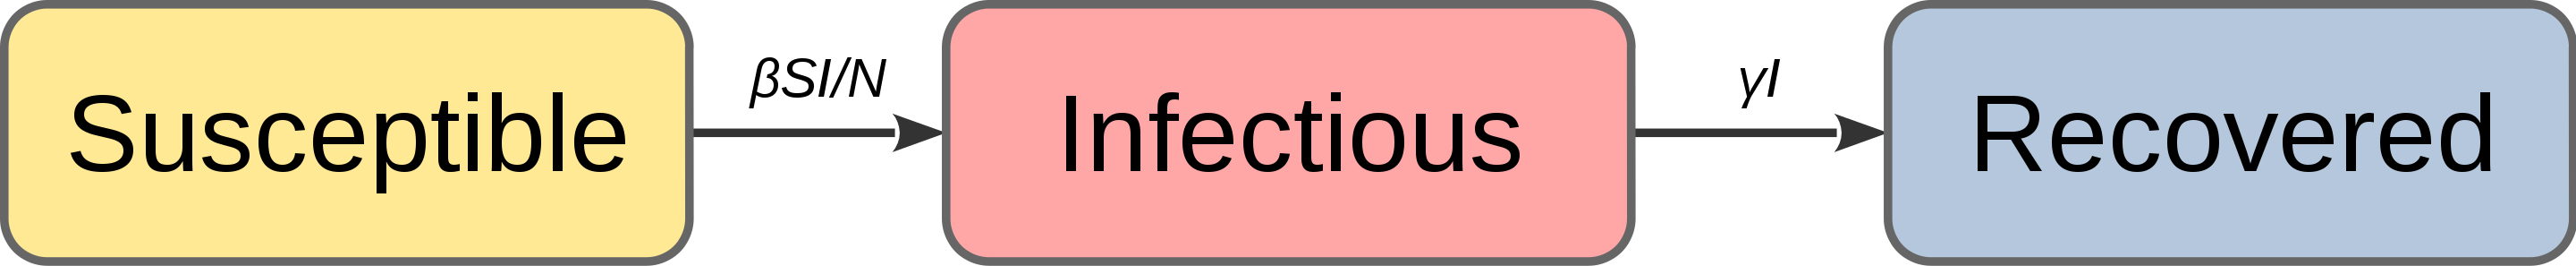

$$\begin{align}
\frac{\partial S}{\partial t} &= D_s \nabla^2 S -\beta \frac{S I}{N} \hspace{20mm}
\frac{\partial I}{\partial t} &= D_i \nabla^2 I + \beta \frac{S I}{N} - \gamma I \hspace{20mm}
\frac{\partial R}{\partial t} &= \gamma I.
\end{align}$$

Source: https://github.com/lukepolson/youtube_channel/blob/main/Python%20Metaphysics%20Series/vid2.ipynb

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

Let $A = (S, I, R)$. Need to define function that takes in $A$ and $t$ and returns $dA/dt = (dS/dt, dI/dt, dR/dt)$

**Parameters and Variables**

- $S$ : Susceptible individuals density (individuals/cm²)
- $I$ : Infectious individuals density (individuals/cm²)
- $R$ : Recovered individuals density (individuals/cm²)
- $\beta$ : Transmission rate (day⁻¹)
- $\gamma$ : Recovery rate (day⁻¹)
- $N$ : Total population
- $D_s$ : Diffusion coefficient for $S$ (cm²/day)
- $D_i$ : Diffusion coefficient for $I$ (cm²/day)

**The Laplace Operator ∇²**

The **Laplace operator** describes spatial diffusion and is defined as the sum of all second spatial derivatives:

$$\nabla^2 u = \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} + \frac{\partial^2 u}{\partial z^2}$$

**Numerical Approximation (Finite Differences)**

For 1D discretization, we approximate the second derivative:

$$\frac{\partial^2 u}{\partial x^2} \approx \frac{u(x+\Delta x) - 2u(x) + u(x-\Delta x)}{(\Delta x)^2}$$

In the code we use `np.roll()` for periodic boundary conditions:
- `np.roll(u, 1)` = value to the left of the point
- `np.roll(u, -1)` = value to the right of the point
- The expression gives the second spatial derivative at each point

In [26]:
def dAdt(A, t, beta, gamma, N, Ds, Di, dx):
    """A ist ein Array mit allen Daten, bestehend aus S, I, R hintereinander. Weshalb A in 3 gleiche Stücke S I R aufgeteilt wird."""
    n_points = len(A) // 3  # Anzahl räumlicher Punkte
    
    S = A[0:n_points]
    I = A[n_points:2*n_points]
    R = A[2*n_points:3*n_points]
    
    # Laplace-Operator mit Finite Differenzen (periodische Randbedingungen) 
    # Räumliche Diffusion berechnen
    laplace_S = (np.roll(S, 1) - 2*S + np.roll(S, -1)) / dx**2 # Verschiebe Array um 1 nach rechts
    laplace_I = (np.roll(I, 1) - 2*I + np.roll(I, -1)) / dx**2 # Verschiebe Array um 1 nach links
    
    # Änderungsraten berechnen
    dS = Ds * laplace_S - beta/N * S * I
    dI = Di * laplace_I + beta/N * S * I - gamma * I
    dR = gamma * I
    
    # Alle Änderungsraten in einem Array zurückgeben, damit odeint sie verarbeiten kann
    return np.concatenate([dS, dI, dR])

**Typical Parameter Values**

- $D_s = 0.01 - 0.1$ cm²/day
- $D_i = 0.01 - 0.1$ cm²/day
- $\beta = 0.1 - 0.5$ day⁻¹
- $\gamma = 0.05 - 0.2$ day⁻¹
- $N = 1000 - 50000$ (total population)

In [50]:
# Parameter
times = np.arange(0, 100, 1)
gamma = 0.1   # day^-1 10% der Kranken genesen pro Tag
beta = 0.3    # day^-1 Ansteckungsrate
Ds = 0.01     # cm^2/day
Di = 0.1     # cm^2/day
dx = 1.0      # spatial grid spacing (cm)
N = 10000

# Räumliches Grid
n_points = 100  # Anzahl der räumlichen Punkte
x = np.linspace(0, n_points*dx, n_points) # gleiche wie x = np.arange(0, 100, 100) 100 Orte neben einander (0 bis 100)

# Anfangsbedingungen: Kranke nur in der Mitte
S0 = np.ones(n_points) * (N - 50) / n_points  # Gesunde überall verteilt (An jedem Ort: 99.5 Gesunde)
I0 = np.zeros(n_points) # An jedem Ort: 0 Kranke
I0[n_points//2-5:n_points//2+5] = 50 / 10  # NUR in der Mitte (Positionen 45-55): 5 Kranke
R0 = np.zeros(n_points) # Überall 0 Genesene

# Kombiniere zu einem langen Array
y0 = np.concatenate([S0, I0, R0])

# Löse das System
"""
odeint rechnet jetzt für jeden Tag, wie sich alle 100 Orte verändern
Ergebnis: Matrix mit 100 Zeilen (Tage) × 300 Spalten (alle S, I, R Werte)
"""
sol = odeint(dAdt, y0, times, args=(beta, gamma, N, Ds, Di, dx))

In [51]:
# sol Array in S, I, R aufteilen
S_solution = sol[:, 0:n_points]
I_solution = sol[:, n_points:2*n_points]
R_solution = sol[:, 2*n_points:3*n_points]

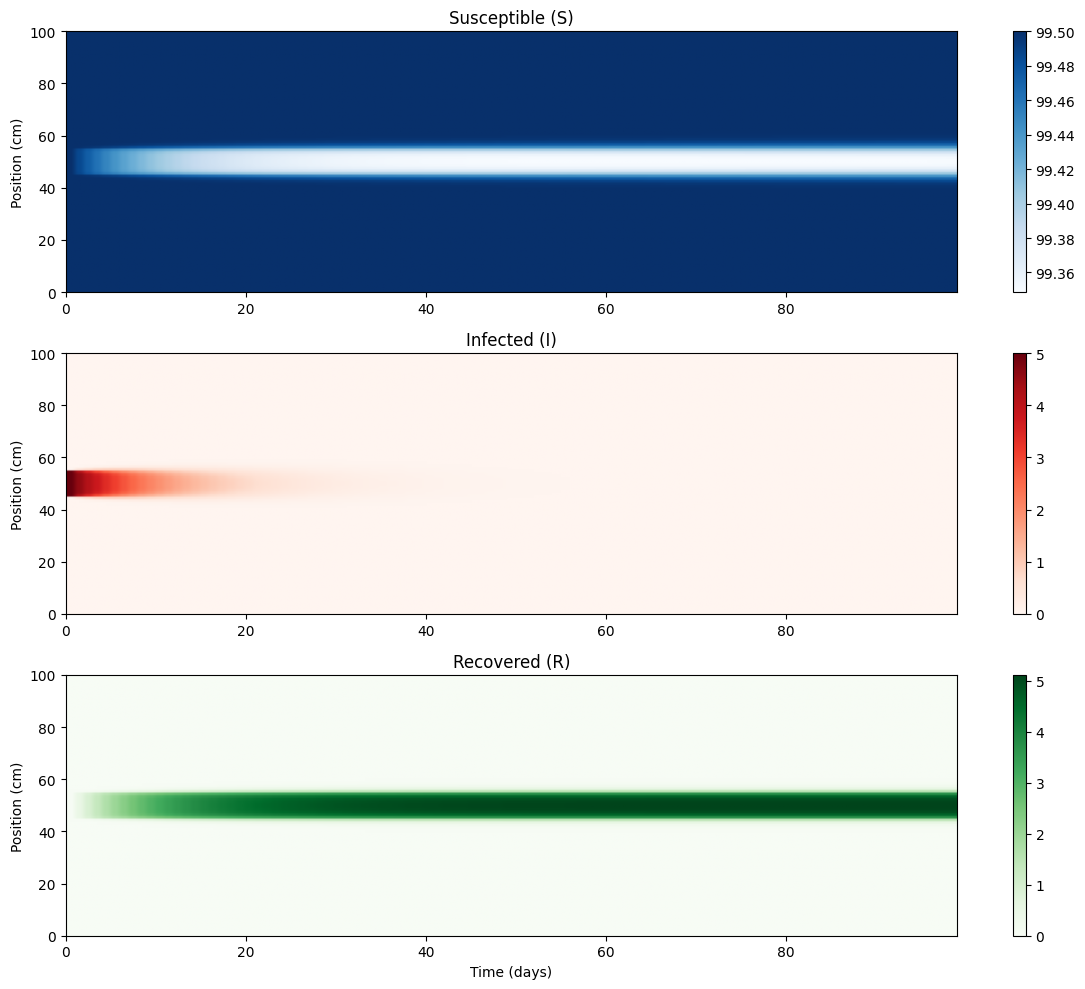

In [52]:
# Visualisierung: Räumlich-zeitliche Heatmap
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

im1 = axes[0].imshow(S_solution.T, aspect='auto', extent=[0, times[-1], 0, x[-1]], 
                     cmap='Blues', origin='lower')
axes[0].set_ylabel('Position (cm)')
axes[0].set_title('Susceptible (S)')
plt.colorbar(im1, ax=axes[0])

im2 = axes[1].imshow(I_solution.T, aspect='auto', extent=[0, times[-1], 0, x[-1]], 
                     cmap='Reds', origin='lower')
axes[1].set_ylabel('Position (cm)')
axes[1].set_title('Infected (I)')
plt.colorbar(im2, ax=axes[1])

im3 = axes[2].imshow(R_solution.T, aspect='auto', extent=[0, times[-1], 0, x[-1]], 
                     cmap='Greens', origin='lower')
axes[2].set_xlabel('Time (days)')
axes[2].set_ylabel('Position (cm)')
axes[2].set_title('Recovered (R)')
plt.colorbar(im3, ax=axes[2])

plt.tight_layout()
plt.show()

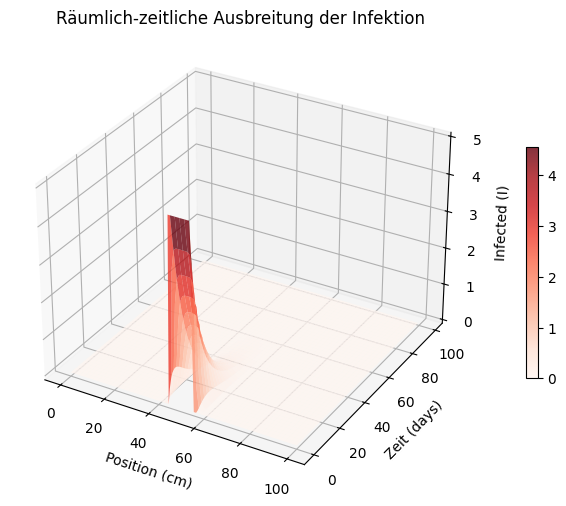

In [53]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14, 6))

# Nur Infected zeigen (am interessantesten)
ax = fig.add_subplot(111, projection='3d')

# Erstelle Meshgrid
X, T = np.meshgrid(x, times)

# Plot als Surface
surf = ax.plot_surface(X, T, I_solution, cmap='Reds', alpha=0.8)

ax.set_xlabel('Position (cm)')
ax.set_ylabel('Zeit (days)')
ax.set_zlabel('Infected (I)')
ax.set_title('Räumlich-zeitliche Ausbreitung der Infektion')
fig.colorbar(surf, ax=ax, shrink=0.5)

plt.show()

Used Claude Ai to simulate the diseas

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from ipywidgets import interact, FloatSlider, IntSlider
import ipywidgets as widgets

def dAdt(A, t, beta, gamma, N, Ds, Di, dx):
    n_points = len(A) // 3
    
    S = A[0:n_points]
    I = A[n_points:2*n_points]
    R = A[2*n_points:3*n_points]
    
    laplace_S = (np.roll(S, 1) - 2*S + np.roll(S, -1)) / dx**2
    laplace_I = (np.roll(I, 1) - 2*I + np.roll(I, -1)) / dx**2
    
    dS = Ds * laplace_S - beta/N * S * I
    dI = Di * laplace_I + beta/N * S * I - gamma * I
    dR = gamma * I
    
    return np.concatenate([dS, dI, dR])

def simulate_and_plot(Ds=0.05, Di=0.05, beta=0.3, gamma=0.1, time_day=25):
    # Setup
    times = np.arange(0, 100, 1)
    N = 10000
    dx = 1.0
    n_points = 100
    x = np.linspace(0, n_points*dx, n_points)
    
    # Initial conditions
    S0 = np.ones(n_points) * (N - 50) / n_points
    I0 = np.zeros(n_points)
    I0[n_points//2-5:n_points//2+5] = 50 / 10
    R0 = np.zeros(n_points)
    y0 = np.concatenate([S0, I0, R0])
    
    # Solve
    sol = odeint(dAdt, y0, times, args=(beta, gamma, N, Ds, Di, dx))
    
    # Extract solutions
    S_solution = sol[:, 0:n_points]
    I_solution = sol[:, n_points:2*n_points]
    R_solution = sol[:, 2*n_points:3*n_points]
    
    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # Spatial distribution at specific time
    time_idx = min(time_day, len(times)-1)
    axes[0].plot(x, S_solution[time_idx, :], 'b-', label='Gesunde (S)', linewidth=2)
    axes[0].plot(x, I_solution[time_idx, :], 'r-', label='Kranke (I)', linewidth=2)
    axes[0].plot(x, R_solution[time_idx, :], 'g-', label='Genesene (R)', linewidth=2)
    axes[0].set_xlabel('Position (cm)', fontsize=12)
    axes[0].set_ylabel('Anzahl', fontsize=12)
    axes[0].set_title(f'Räumliche Verteilung am Tag {time_day}', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)
    axes[0].set_ylim([0, max(S0.max(), 10)])
    
    # Temporal evolution (total)
    total_S = S_solution.sum(axis=1)
    total_I = I_solution.sum(axis=1)
    total_R = R_solution.sum(axis=1)
    
    axes[1].plot(times, total_S, 'b-', label='Gesunde', linewidth=2)
    axes[1].plot(times, total_I, 'r-', label='Kranke', linewidth=2)
    axes[1].plot(times, total_R, 'g-', label='Genesene', linewidth=2)
    axes[1].axvline(time_day, color='purple', linestyle='--', alpha=0.5, label=f'Tag {time_day}')
    axes[1].set_xlabel('Zeit (Tage)', fontsize=12)
    axes[1].set_ylabel('Gesamtanzahl', fontsize=12)
    axes[1].set_title('Zeitliche Entwicklung (Gesamt)', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Info text
    print(f"📊 Parameter: Ds={Ds:.3f}, Di={Di:.3f}, β={beta:.2f}, γ={gamma:.2f}")
    print(f"📍 Maximale Ausbreitung der Kranken: {I_solution.max():.2f} pro Ort")
    print(f"🌍 Räumliche Breite des Ausbruchs: {np.sum(I_solution[time_idx, :] > 0.1)} cm")

# Erstelle interaktive Widgets
interact(
    simulate_and_plot,
    Ds=FloatSlider(min=0.001, max=0.2, step=0.001, value=0.05, description='Ds:', continuous_update=False),
    Di=FloatSlider(min=0.001, max=0.2, step=0.001, value=0.05, description='Di:', continuous_update=False),
    beta=FloatSlider(min=0.1, max=0.5, step=0.01, value=0.3, description='β:', continuous_update=False),
    gamma=FloatSlider(min=0.05, max=0.2, step=0.01, value=0.1, description='γ:', continuous_update=False),
    time_day=IntSlider(min=0, max=99, step=1, value=25, description='Tag:', continuous_update=False)
);

interactive(children=(FloatSlider(value=0.05, continuous_update=False, description='Ds:', max=0.2, min=0.001, …